# Conversão de Variáveis Categóricas

# Parte de Data Science
Autores:
Júlio Limoli,
Marcos Ferreira,
Victor Araki

In [49]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (ConfusionMatrixDisplay, r2_score, accuracy_score, recall_score,
                            roc_auc_score, confusion_matrix, classification_report, precision_score, roc_curve)
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE

import time
from datetime import date
import pickle
import os

sns.set()
pio.templates.default = 'plotly_dark'

## Importando DataFrame 

Já possui separação em treino e validação pelo notebook "split_DE.ipynb"

In [50]:
df = pd.read_csv('./bases/application_splitado_07.csv')
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Flag_Treino
0,456162,False,Cash loans,F,False,False,0,112500.0,700830.0,22738.5,...,False,False,False,0.0,0.0,0.0,0.0,0.0,1.0,True
1,134978,False,Cash loans,F,False,False,0,90000.0,375322.5,14422.5,...,False,False,False,0.0,0.0,0.0,1.0,0.0,3.0,True
2,318952,False,Cash loans,M,True,False,0,180000.0,544491.0,16047.0,...,False,False,False,0.0,0.0,0.0,1.0,1.0,3.0,False
3,361264,False,Cash loans,F,False,True,0,270000.0,814041.0,28971.0,...,False,False,False,0.0,0.0,0.0,0.0,1.0,4.0,True
4,260639,False,Cash loans,F,False,True,0,144000.0,675000.0,21906.0,...,False,False,False,0.0,0.0,0.0,10.0,0.0,0.0,True



# Preenchendo os Valores Omissos – Imputação (Data Cleaning)

In [51]:
#Criando um Dataframe com as colunas e sua respectiva quantidade de valores nulos
cols_w_null_values = pd.DataFrame(df.isnull().sum(), columns = ['Null'])
cols_w_null_values = cols_w_null_values[cols_w_null_values['Null'] != 0]
cols_w_null_values

,Null
AMT_ANNUITY,10
AMT_GOODS_PRICE,226
NAME_TYPE_SUITE,1048
OWN_CAR_AGE,162359
OCCUPATION_TYPE,77237
CNT_FAM_MEMBERS,1
EXT_SOURCE_1,138803
EXT_SOURCE_2,544
EXT_SOURCE_3,48728
APARTMENTS_MEDI,124955


In [52]:
# Removendo linhas com entradas nulas em colunas que apresentam menos do que 1000 observações nulas ()
col_index = cols_w_null_values[cols_w_null_values['Null'] < 1000].index

dict_median_mode = {}

for col in col_index:
    df = df.dropna(subset=list(col_index), axis=0)

#Passando por cada coluna que apresenta valores nulos e fazendo a inserção de dados
for col in cols_w_null_values.index:
    if (col[0:14] == 'AMT_REQ_CREDIT'):
        df[col].fillna(0, inplace=True)  
    elif (df[col].dtypes == int) or (df[col].dtypes == float): #Inserindo a mediana para colunas numéricas
        df[col].fillna(df[col].median(), inplace=True)
        dict_median_mode[col] = df[col].median() 
    else: #Inserindo a moda para os demais tipos de coluna
        df[col].fillna(df[col].mode()[0], inplace=True)
        dict_median_mode[col] = df[col].mode() 

# Conversão de Variáveis Categóricas

In [53]:
df_dummies = pd.get_dummies(df, drop_first = True)
df_dummies.head()

,SK_ID_CURR,TARGET,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
0,456162,False,False,False,0,112500.0,700830.0,22738.5,585000.0,0.019689,...,0,0,0,0,0,0,0,0,0,0
1,134978,False,False,False,0,90000.0,375322.5,14422.5,324000.0,0.025164,...,0,0,0,0,0,0,0,0,0,0
2,318952,False,True,False,0,180000.0,544491.0,16047.0,454500.0,0.035792,...,0,0,0,0,0,0,0,0,0,0
3,361264,False,False,True,0,270000.0,814041.0,28971.0,679500.0,0.046220,...,0,0,0,0,0,0,0,0,0,1
4,260639,False,False,True,0,144000.0,675000.0,21906.0,675000.0,0.026392,...,0,0,0,0,0,0,0,1,0,0


# Separação dos dados de treino e teste

In [54]:
df_train = df_dummies[df_dummies['Flag_Treino'] == True].drop(['Flag_Treino'], axis = 1)
df_test = df_dummies[df_dummies['Flag_Treino'] == False].drop(['Flag_Treino'], axis = 1)

X_train = df_train.drop(['TARGET', 'SK_ID_CURR'], axis = 1)
y_train = df_train['TARGET']

X_test = df_test.drop(['TARGET', 'SK_ID_CURR'], axis = 1)
y_test = df_test['TARGET']

# Analise Exploratória

### Selecao de Features

Foi utilizado o RFC para selecionar as features mais importantes, fez-se testes com 20, 15, 10 features e também utilizando a logistic regression e XGB classifier. Esses testes estão descritos no notebook "parte_DS.ipynb" e o melhor resultado foram as 20 features, mas subtraimos o "OWN_CAR_AGE", visto que 65% do dataset dessa feature era nulo

In [7]:
features_rfc_19 = ['TARGET','AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 
 'DAYS_ID_PUBLISH', 'FLAG_EMP_PHONE', 'REGION_RATING_CLIENT_W_CITY', 
 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'LIVINGAREA_MEDI', 
 'DAYS_LAST_PHONE_CHANGE', 'CODE_GENDER_M', 
 'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_Working', 
 'NAME_EDUCATION_TYPE_Higher education',
 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'ORGANIZATION_TYPE_XNA']

Visto que há muitas features no dataset, a análise exploratória será focada nessas 20 features

In [8]:
df_dummies_rfc_19 = df_dummies[features_rfc_19]

In [9]:
df_dummies_rfc_19.shape

(244419, 20)

In [10]:
df_dummies_rfc_19.describe()

,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,LIVINGAREA_MEDI,DAYS_LAST_PHONE_CHANGE,CODE_GENDER_M,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Secondary / secondary special,ORGANIZATION_TYPE_XNA
count,2.444190e+05,244419.000000,2.444190e+05,244419.000000,244419.000000,244419.000000,244419.000000,244419.000000,2.444190e+05,244419.000000,244419.000000,244419.000000,244419.000000,244419.000000,244419.000000,244419.000000,244419.000000,244419.000000
mean,6.006634e+05,27163.852221,5.394648e+05,-16044.360533,63981.028958,-2992.288742,2.031835,0.504169,5.142685e-01,0.515550,0.091589,-963.634906,0.342150,0.180489,0.516044,0.242588,0.711332,0.180526
std,4.032940e+05,14493.131586,3.701161e+05,4364.871309,141415.252753,1509.790295,0.502607,0.139342,1.909352e-01,0.174863,0.080718,827.213702,0.474431,0.384595,0.499744,0.428649,0.453144,0.384626
min,4.500000e+04,1615.500000,4.050000e+04,-25229.000000,-17912.000000,-7197.000000,1.000000,0.014568,8.173617e-08,0.000527,0.000000,-4292.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.700000e+05,16582.500000,2.385000e+05,-19690.000000,-2759.000000,-4298.000000,2.000000,0.505774,3.924366e-01,0.415347,0.074900,-1571.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.175000e+05,24939.000000,4.500000e+05,-15764.000000,-1216.000000,-3250.000000,2.000000,0.505774,5.655746e-01,0.535276,0.074900,-758.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,8.086500e+05,34659.000000,6.795000e+05,-12420.000000,-289.000000,-1716.000000,2.000000,0.505774,6.634267e-01,0.636376,0.074900,-274.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,4.050000e+06,258025.500000,4.050000e+06,-7489.000000,365243.000000,0.000000,3.000000,0.962693,8.549997e-01,0.896010,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Heatmap

<AxesSubplot:>

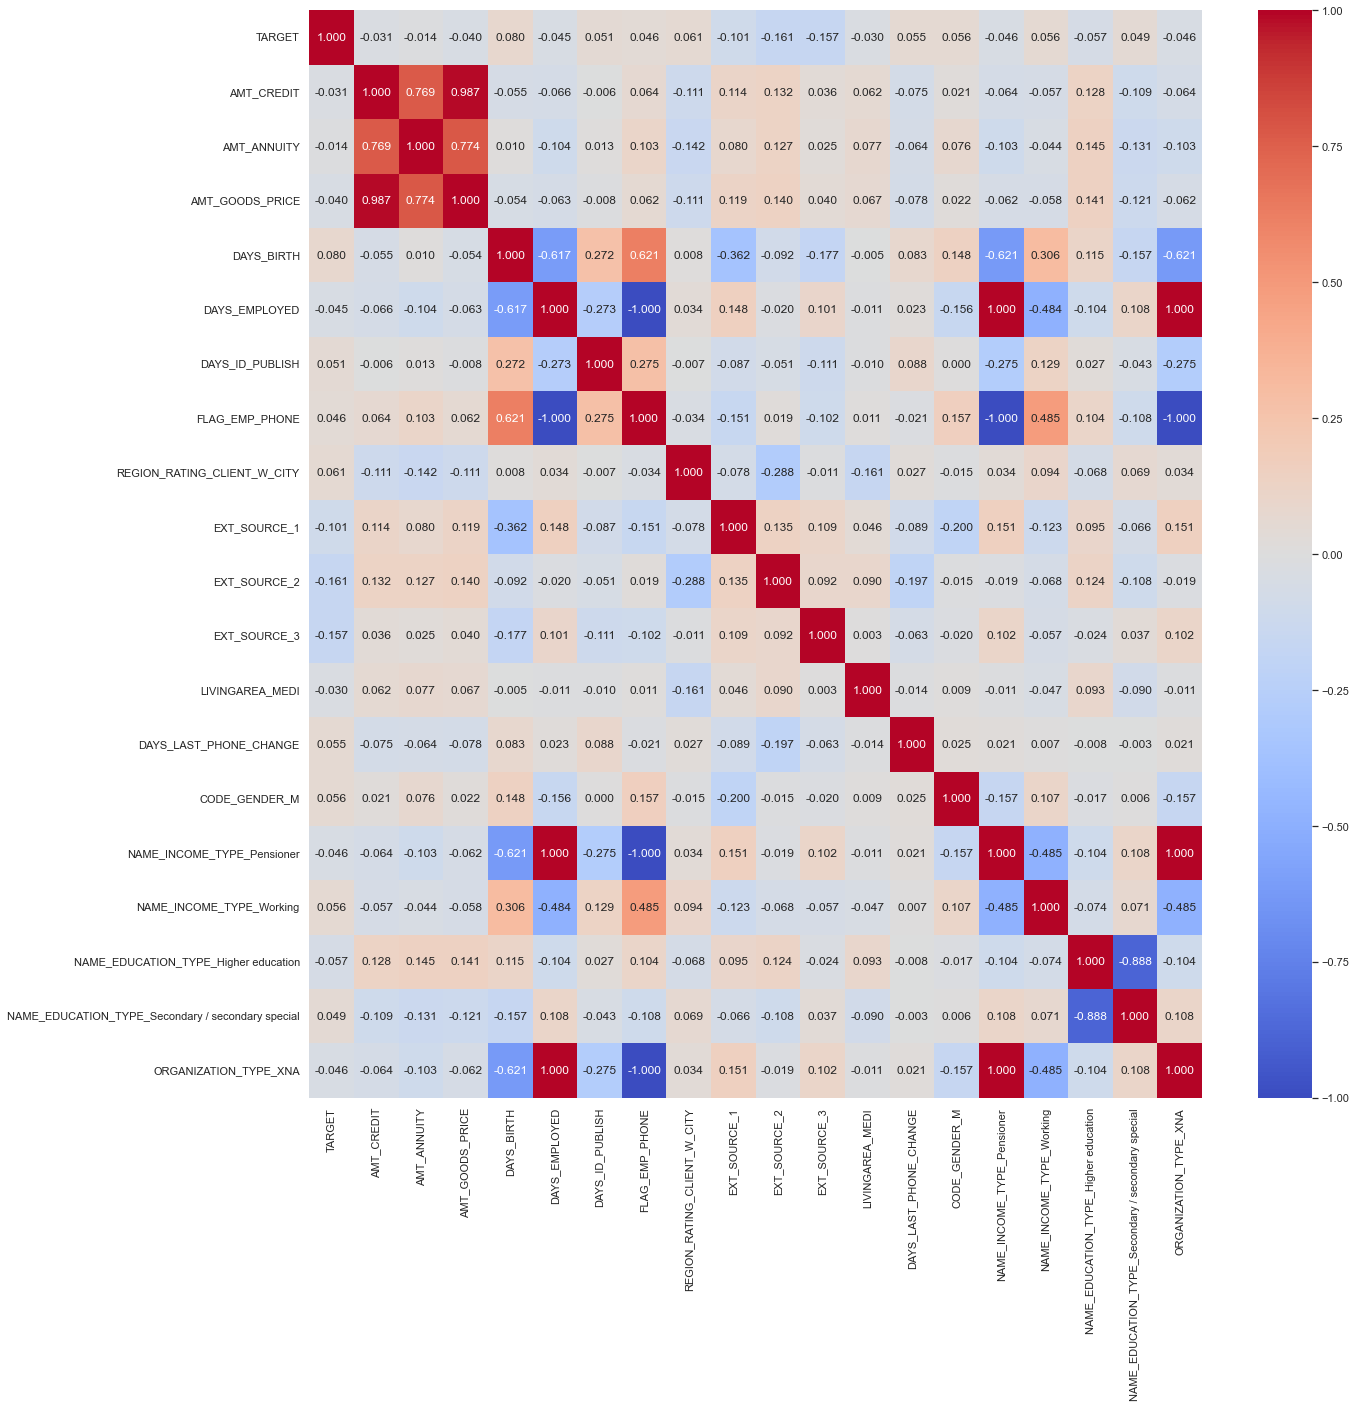

In [11]:
plt.figure(figsize=(20,20))

sns.heatmap(
    data=df_dummies_rfc_19.corr(), 
    cmap='coolwarm', 
    annot=True, 
    vmax=1, 
    vmin=-1,
    fmt='.3f'
    )

Após analisar o heatmap, decidimos excluir 4 features que possuem forte correlação com outras. </br>
NAME_INCOME_TYPE_Pensioner </br>
ORGANIZATION_TYPE_XNA </br>
AMT_CREDIT </br>
FLAG_EMP_PHONE

In [12]:
df_dummies_rfc_15 = df_dummies_rfc_19.drop(['NAME_INCOME_TYPE_Pensioner', 'ORGANIZATION_TYPE_XNA', 'AMT_CREDIT', 'FLAG_EMP_PHONE'], axis=1)

<AxesSubplot:>

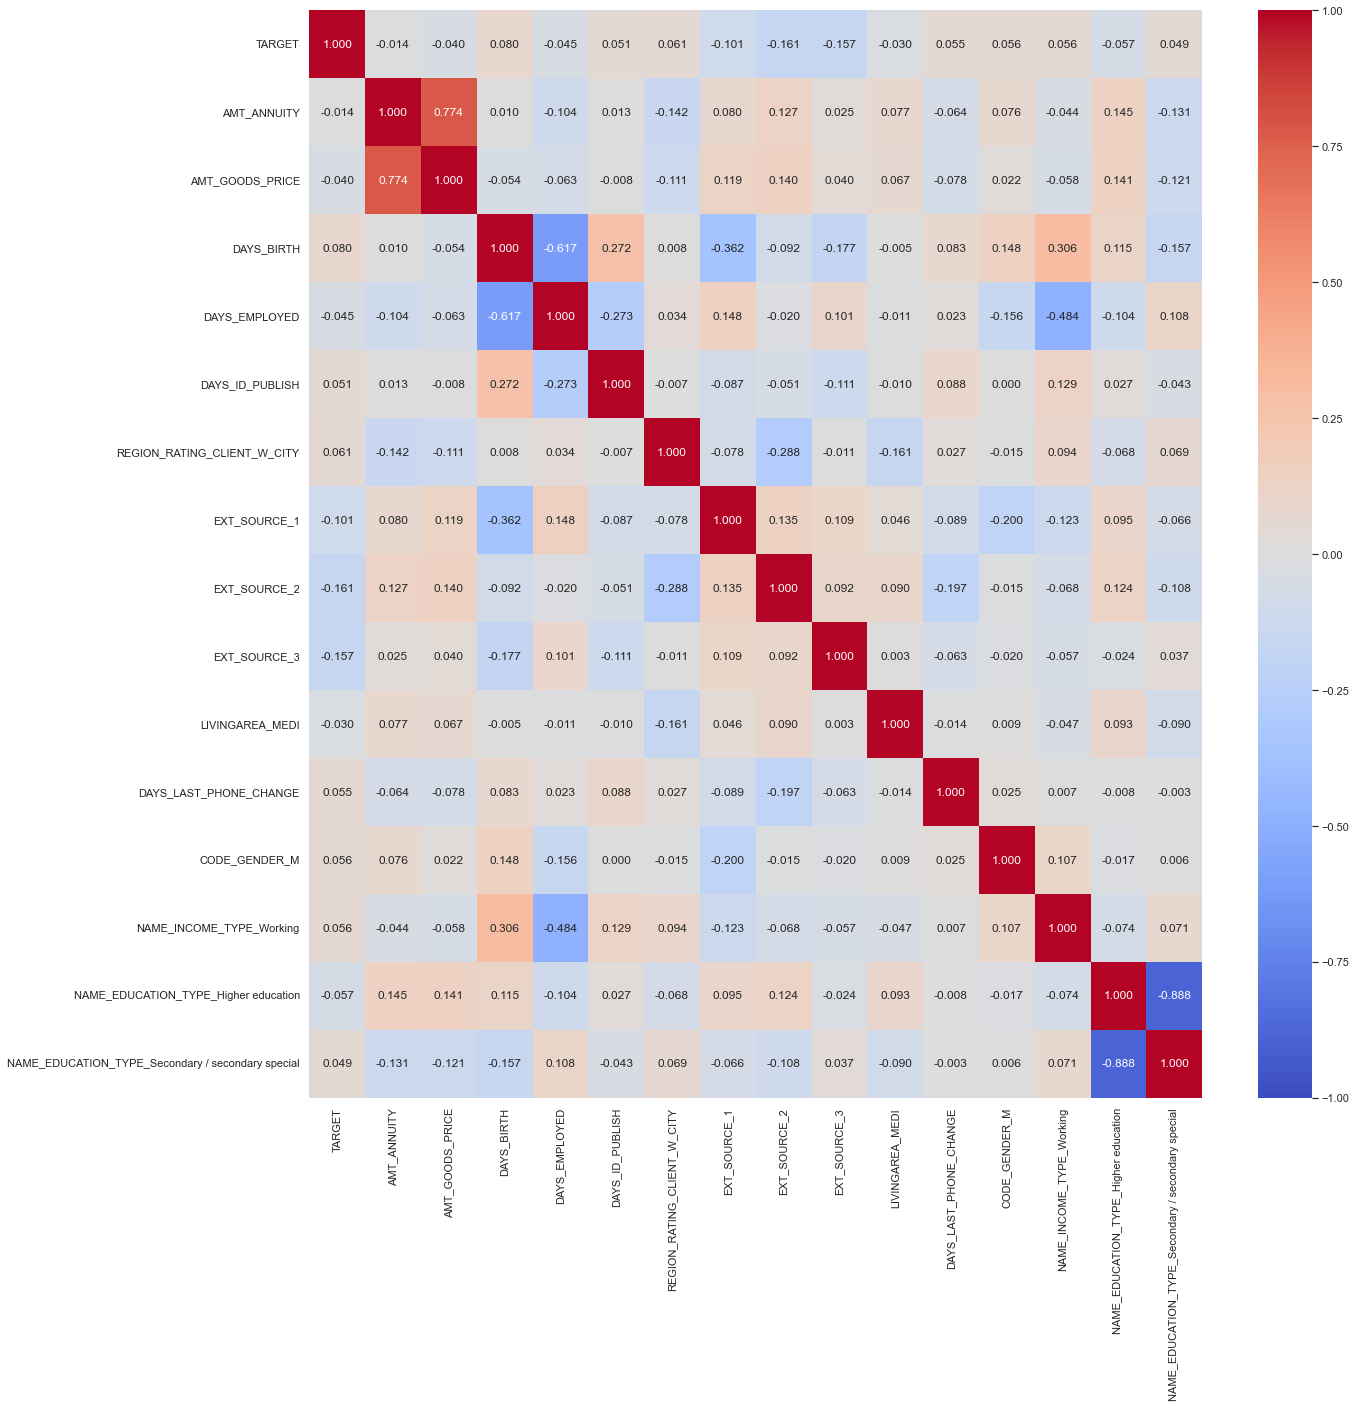

In [13]:
plt.figure(figsize=(20,20))

sns.heatmap(
    data=df_dummies_rfc_15.corr(), 
    cmap='coolwarm', 
    annot=True, 
    vmax=1, 
    vmin=-1,
    fmt='.3f'
    )

# Balanceamento de Amostras

In [9]:
#É possível ver que existe um desbalanceamento na variável de estudo.
df_dummies['TARGET'].value_counts()

False    224541
True      19878
Name: TARGET, dtype: int64

<AxesSubplot:xlabel='TARGET', ylabel='count'>

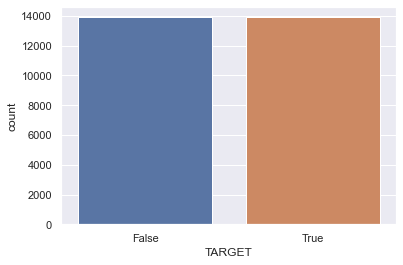

In [10]:
#Para contornar esse problema utilizaremos o RandomUnderSampler para fazer o balanceamento de amostras.
X_train, y_train = RandomUnderSampler(random_state=42).fit_resample(X_train, y_train)

sns.countplot(x=y_train)

In [11]:
lr_model = LogisticRegression(max_iter=10000, random_state = 42)
xgb_model = XGBClassifier(random_state = 42, n_estimator = 20, verbosity = 0)
rfc_model = RandomForestClassifier(max_depth=5, random_state = 42)

In [69]:
dict_models = {
    'nome_modelo': [],
    'data_treino': [],
    'metodo': [],
    'roc_auc': [],
    'tempo_treino': [],
    'hyperparametros': [],
    'path_to_pickle': []
}

In [12]:
def models_table(model_name, model, X_train, y_train, X_test, y_test):
    dict_models['nome_modelo'].append(model_name)

    data_treino = date.today().isoformat()
    dict_models['data_treino'].append(data_treino)

    metodo = str(model).split(sep="(")[0]
    dict_models['metodo'].append(metodo)

    tempo_inicio = time.time()
    model.fit(X = X_train, y = y_train)
    tempo_fim = time.time()
    tempo_total = tempo_fim - tempo_inicio
    dict_models['tempo_treino'].append(tempo_total)

    y_pred_proba_test = model.predict_proba(X_test)
    roc_auc = roc_auc_score(y_true=y_test, y_score=y_pred_proba_test[:,1])
    dict_models['roc_auc'].append(roc_auc)

    hyperparams = model.get_params()
    dict_models['hyperparametros'].append(hyperparams)

    #Salvar no pickle
    os.makedirs('./pickle', exist_ok=True)  #Checa se existe a pasta, se nao existir cria
    name_file = model_name + '.pkl'
    file_path = './pickle/'+ name_file

    #Checagem se ja existe pickle com mesmo nome
    file_exists = os.path.exists(file_path)
    if file_exists:
         raise Exception("Ja existe um pickle com esse nome, mude o nome do modelo")

    with open(file_path, 'wb') as file:
        pickle.dump(model, file)

    dict_models['path_to_pickle'].append('/FileStore/tables/modelos' + file_path[1:])
    
    print(f'ROC_AUC para {metodo}: {roc_auc}')

# Seleção de Features

### Testando Modelos usando todas as features

In [71]:
#Treinando um modelo de Losgistic Regression utilizando todas as features:
models_table(
    model_name='Logistic Regression todas as features', 
    model=lr_model,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test
    )

#Treinando um modelo de XGB Classifier utilizando todas as features:
models_table(
    model_name='XGBoost Classifier todas as features', 
    model=xgb_model,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test
    )

#Treinando um modelo de Random Forest Classifier utilizando todas as features:
models_table(
    model_name='Random Forest Classifier todas as features', 
    model=rfc_model,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test
    )

ROC_AUC para LogisticRegression: 0.6061155710368177


C:\Users\Marcos Peixoto\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Marcos Peixoto\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


ROC_AUC para XGBClassifier: 0.7404736433137908
ROC_AUC para RandomForestClassifier: 0.7237788226645465


# Seleção de Features - Logistic Regression (20 features)

In [20]:
model = LogisticRegression(max_iter=10000, random_state = 42)
rfe = RFE(model, n_features_to_select = 20)
fit = rfe.fit(X_train, y_train)

features_lr_20 = rfe.get_feature_names_out()
print(f"Features Selecionadas: {features_lr_20}")

ROC_AUC para RFE: 0.6061389508524226
Features Selecionadas: ['AMT_CREDIT' 'AMT_ANNUITY' 'AMT_GOODS_PRICE' 'DAYS_BIRTH' 'DAYS_EMPLOYED'
 'DAYS_REGISTRATION' 'DAYS_ID_PUBLISH' 'OWN_CAR_AGE' 'CNT_FAM_MEMBERS'
 'REGION_RATING_CLIENT' 'REGION_RATING_CLIENT_W_CITY'
 'HOUR_APPR_PROCESS_START' 'EXT_SOURCE_2' 'OBS_30_CNT_SOCIAL_CIRCLE'
 'OBS_60_CNT_SOCIAL_CIRCLE' 'DAYS_LAST_PHONE_CHANGE'
 'AMT_REQ_CREDIT_BUREAU_YEAR' 'CODE_GENDER_M' 'NAME_INCOME_TYPE_Working'
 'NAME_EDUCATION_TYPE_Secondary / secondary special']


### Testando Modelos usando todas as 20 features encontradas

In [72]:
#Treinando um modelo de Losgistic Regression utilizando todas as features:
models_table(
    model_name='Logistic Regression 20 features', 
    model=lr_model,
    X_train=X_train[features_lr_20],
    y_train=y_train,
    X_test=X_test[features_lr_20],
    y_test=y_test
    )

#Treinando um modelo de XGB Classifier utilizando todas as features:
models_table(
    model_name='XGBoost Classifier 20 features', 
    model=xgb_model,
    X_train=X_train[features_lr_20],
    y_train=y_train,
    X_test=X_test[features_lr_20],
    y_test=y_test
    )

#Treinando um modelo de Random Forest Classifier utilizando todas as features:
models_table(
    model_name='Random Forest Classifier 20 features', 
    model=rfc_model,
    X_train=X_train[features_lr_20],
    y_train=y_train,
    X_test=X_test[features_lr_20],
    y_test=y_test
    )

ROC_AUC para LogisticRegression: 0.6061389508524226


C:\Users\Marcos Peixoto\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Marcos Peixoto\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


ROC_AUC para XGBClassifier: 0.6920799095522621
ROC_AUC para RandomForestClassifier: 0.6940659796013349


# Seleção de Features - Logistic Regression (15 features)

In [22]:
model = LogisticRegression(max_iter=10000, random_state = 42)
rfe = RFE(model, n_features_to_select = 15)
fit = rfe.fit(X_train, y_train)

features_lr_15 = rfe.get_feature_names_out()
print(f"Features Selecionadas: {features_lr_15}")

ROC_AUC para RFE: 0.6061382665772747
Features Selecionadas: ['AMT_CREDIT' 'AMT_ANNUITY' 'AMT_GOODS_PRICE' 'DAYS_BIRTH' 'DAYS_EMPLOYED'
 'DAYS_REGISTRATION' 'DAYS_ID_PUBLISH' 'OWN_CAR_AGE'
 'REGION_RATING_CLIENT' 'REGION_RATING_CLIENT_W_CITY'
 'HOUR_APPR_PROCESS_START' 'OBS_30_CNT_SOCIAL_CIRCLE'
 'OBS_60_CNT_SOCIAL_CIRCLE' 'DAYS_LAST_PHONE_CHANGE'
 'AMT_REQ_CREDIT_BUREAU_YEAR']


### Testando Modelos usando todas as 15 features encontradas

In [73]:
#Treinando um modelo de Losgistic Regression utilizando todas as features:
models_table(
    model_name='Logistic Regression 15 features', 
    model=lr_model,
    X_train=X_train[features_lr_15],
    y_train=y_train,
    X_test=X_test[features_lr_15],
    y_test=y_test
    )

#Treinando um modelo de XGB Classifier utilizando todas as features:
models_table(
    model_name='XGBoost Classifier 15 features', 
    model=xgb_model,
    X_train=X_train[features_lr_15],
    y_train=y_train,
    X_test=X_test[features_lr_15],
    y_test=y_test
    )

#Treinando um modelo de Random Forest Classifier utilizando todas as features:
models_table(
    model_name='Random Forest Classifier 15 features', 
    model=rfc_model,
    X_train=X_train[features_lr_15],
    y_train=y_train,
    X_test=X_test[features_lr_15],
    y_test=y_test
    )

ROC_AUC para LogisticRegression: 0.6061382665772747


C:\Users\Marcos Peixoto\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Marcos Peixoto\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


ROC_AUC para XGBClassifier: 0.6506159073518323
ROC_AUC para RandomForestClassifier: 0.6484663876084787


# Seleção de Features - Logistic Regression (10 features)

In [24]:
model = LogisticRegression(max_iter=10000, random_state = 42)
rfe = RFE(model, n_features_to_select = 10)
fit = rfe.fit(X_train, y_train)

features_lr_10 = rfe.get_feature_names_out()

print(f"Número de Features: {rfe.n_features_to_select}")
print(f"Features Selecionadas: {features_lr_10}")

Número de Features: 10
Features Selecionadas: ['AMT_CREDIT' 'AMT_ANNUITY' 'AMT_GOODS_PRICE' 'DAYS_BIRTH' 'DAYS_EMPLOYED'
 'DAYS_REGISTRATION' 'DAYS_ID_PUBLISH' 'OWN_CAR_AGE'
 'HOUR_APPR_PROCESS_START' 'DAYS_LAST_PHONE_CHANGE']


### Testando Modelos usando todas as 10 features encontradas

In [74]:
#Treinando um modelo de Losgistic Regression utilizando todas as features:
models_table(
    model_name='Logistic Regression 10 features', 
    model=lr_model,
    X_train=X_train[features_lr_10],
    y_train=y_train,
    X_test=X_test[features_lr_10],
    y_test=y_test
    )

#Treinando um modelo de XGB Classifier utilizando todas as features:
models_table(
    model_name='XGBoost Classifier 10 features', 
    model=xgb_model,
    X_train=X_train[features_lr_10],
    y_train=y_train,
    X_test=X_test[features_lr_10],
    y_test=y_test
    )

#Treinando um modelo de Random Forest Classifier utilizando todas as features:
models_table(
    model_name='Random Forest Classifier 10 features', 
    model=rfc_model,
    X_train=X_train[features_lr_10],
    y_train=y_train,
    X_test=X_test[features_lr_10],
    y_test=y_test
    )

ROC_AUC para LogisticRegression: 0.6061364476495172


C:\Users\Marcos Peixoto\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Marcos Peixoto\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


ROC_AUC para XGBClassifier: 0.6441556482608762
ROC_AUC para RandomForestClassifier: 0.6421791070542746


In [26]:
print('A partir da análise dos resultados, podemos ver que 20 é uma boa quantidade de features para o nosso modelo, tendo em vista que o resultado final não é muito impactado e que a redução diminui a complexidade do problema.')

A partir da análise dos resultados, podemos ver que 20 é uma boa quantidade de features para o nosso modelo, tendo em vista que o resultado final não é muito impactado e que a redução diminui a complexidade do problema.


# Seleção de Features - Random Forest (20 features)

In [27]:
model = RandomForestClassifier(max_depth=5, random_state = 42)
rfe = RFE(model, n_features_to_select = 20)
fit = rfe.fit(X_train, y_train)

features_rfc_20 = rfe.get_feature_names_out()
print(f"Features Selecionadas: {features_rfc_20}")

Número de Features: 20
Features Selecionadas: ['AMT_CREDIT' 'AMT_ANNUITY' 'AMT_GOODS_PRICE' 'DAYS_BIRTH' 'DAYS_EMPLOYED'
 'DAYS_REGISTRATION' 'DAYS_ID_PUBLISH' 'OWN_CAR_AGE' 'FLAG_EMP_PHONE'
 'REGION_RATING_CLIENT' 'REGION_RATING_CLIENT_W_CITY' 'EXT_SOURCE_1'
 'EXT_SOURCE_2' 'EXT_SOURCE_3' 'DAYS_LAST_PHONE_CHANGE' 'CODE_GENDER_M'
 'NAME_INCOME_TYPE_Pensioner' 'NAME_INCOME_TYPE_Working'
 'NAME_EDUCATION_TYPE_Higher education'
 'NAME_EDUCATION_TYPE_Secondary / secondary special']


### Testando Modelos usando todas as 20 features encontradas

In [75]:
#Treinando um modelo de Losgistic Regression utilizando todas as features:
models_table(
    model_name='Logistic Regression 20 features (escolhidas RFC)', 
    model=lr_model,
    X_train=X_train[features_rfc_20],
    y_train=y_train,
    X_test=X_test[features_rfc_20],
    y_test=y_test
    )

#Treinando um modelo de XGB Classifier utilizando todas as features:
models_table(
    model_name='XGBoost Classifier 20 features (escolhidas RFC)', 
    model=xgb_model,
    X_train=X_train[features_rfc_20],
    y_train=y_train,
    X_test=X_test[features_rfc_20],
    y_test=y_test
    )

#Treinando um modelo de Random Forest Classifier utilizando todas as features:
models_table(
    model_name='Random Forest Classifier 20 features (escolhidas RFC)', 
    model=rfc_model,
    X_train=X_train[features_rfc_20],
    y_train=y_train,
    X_test=X_test[features_rfc_20],
    y_test=y_test
    )

ROC_AUC para LogisticRegression: 0.606137428029184


C:\Users\Marcos Peixoto\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Marcos Peixoto\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


ROC_AUC para XGBClassifier: 0.7364817637438281
ROC_AUC para RandomForestClassifier: 0.7339025702170809


In [29]:
print('Podemos ver uma melhora ascentuda no resultado dos modelos quando utilizamos a feature selection da Random Forest Classifier.')

Podemos ver uma melhora ascentuda no resultado dos modelos quando utilizamos a feature selection da Random Forest Classifier.


# Seleção de Features - XGB Classifier (20 features)

In [30]:
model = XGBClassifier(random_state = 42, n_estimator = 10, verbosity = 0)
rfe = RFE(model, n_features_to_select = 20)
fit = rfe.fit(X_train, y_train)

features_xgbc_20 = rfe.get_feature_names_out()
print(f"Features Selecionadas: {features_xgbc_20}")

C:\Users\Marcos Peixoto\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Marcos Peixoto\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Marcos 

Número de Features: 20
Features Selecionadas: ['FLAG_OWN_CAR' 'AMT_GOODS_PRICE' 'DAYS_BIRTH' 'REG_CITY_NOT_LIVE_CITY'
 'EXT_SOURCE_1' 'EXT_SOURCE_2' 'EXT_SOURCE_3' 'DEF_30_CNT_SOCIAL_CIRCLE'
 'DEF_60_CNT_SOCIAL_CIRCLE' 'FLAG_DOCUMENT_14' 'FLAG_DOCUMENT_16'
 'NAME_CONTRACT_TYPE_Revolving loans' 'CODE_GENDER_M'
 'NAME_EDUCATION_TYPE_Higher education'
 'NAME_HOUSING_TYPE_Office apartment' 'OCCUPATION_TYPE_Core staff'
 'OCCUPATION_TYPE_Drivers' 'WEEKDAY_APPR_PROCESS_START_SUNDAY'
 'ORGANIZATION_TYPE_Construction' 'ORGANIZATION_TYPE_Industry: type 9']


In [76]:
#Treinando um modelo de Losgistic Regression utilizando todas as features:
models_table(
    model_name='Logistic Regression 20 features (escolhidas XGBC)', 
    model=lr_model,
    X_train=X_train[features_xgbc_20],
    y_train=y_train,
    X_test=X_test[features_xgbc_20],
    y_test=y_test
    )

#Treinando um modelo de XGB Classifier utilizando todas as features:
models_table(
    model_name='XGBoost Classifier 20 features (escolhidas XGBC)', 
    model=xgb_model,
    X_train=X_train[features_xgbc_20],
    y_train=y_train,
    X_test=X_test[features_xgbc_20],
    y_test=y_test
    )

#Treinando um modelo de Random Forest Classifier utilizando todas as features:
models_table(
    model_name='Random Forest Classifier 20 features (escolhidas XGBC)', 
    model=rfc_model,
    X_train=X_train[features_xgbc_20],
    y_train=y_train,
    X_test=X_test[features_xgbc_20],
    y_test=y_test
    )

ROC_AUC para LogisticRegression: 0.5706878597545488


C:\Users\Marcos Peixoto\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Marcos Peixoto\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


ROC_AUC para XGBClassifier: 0.7365067634253292
ROC_AUC para RandomForestClassifier: 0.7328240779355055


In [32]:
print('Os resultados são muito próximos dos resultados encontrados na seleção de features utilizando o random forest classifier. Portanto, optaremos por seguir utilizando as features selecionadas pelo RFC, já que a necessidade de processamento necessária para realizar essa seleção é muito menor.')

Os resultados são muito próximos dos resultados encontrados na seleção de features utilizando o random forest classifier. Portanto, optaremos por seguir utilizando as features selecionadas pelo RFC, já que a necessidade de processamento necessária para realizar essa seleção é muito menor.


# Criação de Modelos

## Modelo com as features definidas pela RFC

## Modelo com features que apresentaram correlação alta removidas:

In [2]:
features_rfc_15 = ['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 
 'DAYS_ID_PUBLISH', 'REGION_RATING_CLIENT_W_CITY', 
 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'LIVINGAREA_MEDI', 
 'DAYS_LAST_PHONE_CHANGE', 'CODE_GENDER_M', 
 'NAME_INCOME_TYPE_Working', 
 'NAME_EDUCATION_TYPE_Higher education',
 'NAME_EDUCATION_TYPE_Secondary / secondary special']

In [77]:
#Treinando um modelo de Losgistic Regression utilizando todas as features:
models_table(
    model_name='Logistic Regression 15 features (escolhidas RFC)', 
    model=lr_model,
    X_train=X_train[features_rfc_15],
    y_train=y_train,
    X_test=X_test[features_rfc_15],
    y_test=y_test
    )

#Treinando um modelo de XGB Classifier utilizando todas as features:
models_table(
    model_name='XGBoost Classifier 15 features (escolhidas RFC)', 
    model=xgb_model,
    X_train=X_train[features_rfc_15],
    y_train=y_train,
    X_test=X_test[features_rfc_15],
    y_test=y_test
    )

#Treinando um modelo de Random Forest Classifier utilizando todas as features:
models_table(
    model_name='Random Forest Classifier 15 features (escolhidas RFC)', 
    model=rfc_model,
    X_train=X_train[features_rfc_15],
    y_train=y_train,
    X_test=X_test[features_rfc_15],
    y_test=y_test
    )

ROC_AUC para LogisticRegression: 0.5923753783170673


C:\Users\Marcos Peixoto\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Marcos Peixoto\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


ROC_AUC para XGBClassifier: 0.732214942419366
ROC_AUC para RandomForestClassifier: 0.7359974350381522


In [35]:
print('Podemos ver que a remoção das 4 variáveis que apresentaram uma correlação alta impactou muito pouco o ROC_AUC. Por conta disso, nosso modelo final não levará em consideração essas variáveis.')

Podemos ver que a remoção das 4 variáveis que apresentaram uma correlação alta impactou muito pouco o ROC_AUC. Por conta disso, nosso modelo final não levará em consideração essas variáveis.


# Criando Tabela com resultado dos Modelos

In [78]:
model_df = pd.DataFrame(dict_models)
model_df.to_csv('dados_modelos.csv')
model_df = model_df.sort_values(by = 'roc_auc', ascending = False)
model_df

,nome_modelo,data_treino,metodo,roc_auc,tempo_treino,hyperparametros,path_to_pickle
1,XGBoost Classifier todas as features,2022-03-11,XGBClassifier,0.740474,27.075549,"{'objective': 'binary:logistic', 'use_label_en...",/FileStore/tables/modelos/pickle/XGBoost Class...
16,XGBoost Classifier 20 features (escolhidas XGBC),2022-03-11,XGBClassifier,0.736507,3.601206,"{'objective': 'binary:logistic', 'use_label_en...",/FileStore/tables/modelos/pickle/XGBoost Class...
13,XGBoost Classifier 20 features (escolhidas RFC),2022-03-11,XGBClassifier,0.736482,4.956283,"{'objective': 'binary:logistic', 'use_label_en...",/FileStore/tables/modelos/pickle/XGBoost Class...
20,Random Forest Classifier 15 features (escolhid...,2022-03-11,RandomForestClassifier,0.735997,2.448140,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",/FileStore/tables/modelos/pickle/Random Forest...
14,Random Forest Classifier 20 features (escolhid...,2022-03-11,RandomForestClassifier,0.733903,2.768158,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",/FileStore/tables/modelos/pickle/Random Forest...
17,Random Forest Classifier 20 features (escolhid...,2022-03-11,RandomForestClassifier,0.732824,1.702097,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",/FileStore/tables/modelos/pickle/Random Forest...
19,XGBoost Classifier 15 features (escolhidas RFC),2022-03-11,XGBClassifier,0.732215,4.211241,"{'objective': 'binary:logistic', 'use_label_en...",/FileStore/tables/modelos/pickle/XGBoost Class...
2,Random Forest Classifier todas as features,2022-03-11,RandomForestClassifier,0.723779,3.037174,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",/FileStore/tables/modelos/pickle/Random Forest...
5,Random Forest Classifier 20 features,2022-03-11,RandomForestClassifier,0.694066,2.922167,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",/FileStore/tables/modelos/pickle/Random Forest...
4,XGBoost Classifier 20 features,2022-03-11,XGBClassifier,0.692080,4.890280,"{'objective': 'binary:logistic', 'use_label_en...",/FileStore/tables/modelos/pickle/XGBoost Class...


# Predição

Optamos por selecionar, como modelo final, o modelo de id 20 (Random Forest Classifier 15 features). Essa escolha foi feita por esse ser o modelo treinado com a menor quantidade de features e cujo o roc_auc não foi prejudicado.

In [93]:
df_test_student = pd.read_csv('./bases/application_test_student.csv')


# Preenchendo os Valores Omissos – Imputação (Data Cleaning)

In [94]:
#Criando um Dataframe com as colunas e sua respectiva quantidade de valores nulos
cols_w_null_values = pd.DataFrame(df_test_student.isnull().sum(), columns = ['Null'])
cols_w_null_values = cols_w_null_values[cols_w_null_values['Null'] != 0]
cols_w_null_values

,Null
AMT_GOODS_PRICE,2
NAME_TYPE_SUITE,5
OWN_CAR_AGE,649
OCCUPATION_TYPE,306
EXT_SOURCE_1,559
EXT_SOURCE_2,1
EXT_SOURCE_3,191
APARTMENTS_MEDI,477
BASEMENTAREA_MEDI,566
YEARS_BEGINEXPLUATATION_MEDI,466


In [95]:
# Removendo linhas com entradas nulas em colunas que apresentam menos do que 1000 observações nulas ()
col_index = cols_w_null_values[cols_w_null_values['Null'] < 6].index


for col in col_index:
    df_test_student = df_test_student.dropna(subset=list(col_index), axis=0)

#Passando por cada coluna que apresenta valores nulos e fazendo a inserção de dados
for col in cols_w_null_values.index:
    if (col[0:14] == 'AMT_REQ_CREDIT'):
        df_test_student[col].fillna(0, inplace=True)  
    elif (df_test_student[col].dtypes == int) or (df_test_student[col].dtypes == float): #Inserindo a mediana para colunas numéricas
        df_test_student[col].fillna(dict_median_mode[col], inplace=True)
    else: #Inserindo a moda para os demais tipos de coluna
        df_test_student[col].fillna(dict_median_mode[col], inplace=True)

# Conversão de Variáveis Categóricas

In [96]:
df_test_student_dummies = pd.get_dummies(df_test_student)
df_test_student_dummies

,SK_ID_CURR,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
0,149741,False,False,0,117000.0,417024.0,20191.5,360000.0,0.020246,-21774,...,0,0,0,0,0,0,0,0,0,0
1,363290,False,True,0,450000.0,640080.0,31261.5,450000.0,0.046220,-18499,...,0,0,0,0,0,0,0,0,0,0
3,377703,True,False,1,360000.0,1125000.0,33025.5,1125000.0,0.018634,-12319,...,0,0,0,0,0,0,0,0,0,0
4,188624,True,True,0,675000.0,835380.0,42840.0,675000.0,0.020713,-10151,...,0,0,0,0,0,0,0,1,0,0
5,454397,True,True,2,112500.0,455040.0,12510.0,360000.0,0.018634,-20176,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,389889,False,True,1,76500.0,197820.0,15664.5,180000.0,0.030755,-17204,...,0,0,0,0,0,0,0,0,0,0
996,340350,True,True,2,90000.0,438493.5,26626.5,333000.0,0.018801,-12093,...,0,0,0,0,0,0,0,0,0,0
997,231590,False,True,1,261000.0,137538.0,14940.0,121500.0,0.007114,-16428,...,0,0,0,0,0,0,0,0,0,0
998,394955,False,True,1,112500.0,325908.0,14485.5,247500.0,0.010643,-15458,...,0,0,0,0,0,0,0,0,0,0


# Seleção de Features

In [97]:
df_test_student_dummies = df_test_student_dummies.set_index('SK_ID_CURR')
X_test_student = df_test_student_dummies[features_rfc_15]

# Aplicando o Modelo

In [98]:
pickled_model = pickle.load(open('./pickle/Random Forest Classifier 15 features (escolhidas RFC).pkl', 'rb'))
X_test_student['proba'] = pickled_model.predict_proba(X_test_student)[:,1]

C:\Users\MARCOS~1\AppData\Local\Temp/ipykernel_8272/555698293.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_student['proba'] = pickled_model.predict_proba(X_test_student)[:,1]


# Exportando o Resultado

In [100]:
X_proba = X_test_student[['proba']]
X_proba.to_csv('resultado_test_student.csv')